# NBA Game Prediction - Data Wrangling (Season 2022+)

This notebook prepares the data for modeling NBA game outcomes. We'll:
1. Load game data from `team_traditional.csv` (filtered to season 2022+)
2. Calculate advanced metrics (OFF_RTG, DEF_RTG, NET_RTG, PACE, TO%, etc.)
3. Calculate rolling features (last 10 games) - **no data leakage**
4. Create matchup dataset (home vs away)
5. Save processed data for modeling

**Key principle**: Only use data available BEFORE each game (point-in-time features)

## 1. Setup and Load Data


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)

print("Packages loaded successfully!")


Packages loaded successfully!


In [2]:
# Load game data
games = pd.read_csv('team_traditional.csv')

# Convert date to datetime and sort by team and date
games['date'] = pd.to_datetime(games['date'])

# Filter to season 2022 onwards
games = games[games['season'] >= 2022].copy()

print(f"Loaded {len(games):,} games (season 2022+)")
print(f"Date range: {games['date'].min().date()} to {games['date'].max().date()}")
print(f"Teams: {games['team'].nunique()}")
print(f"Seasons: {sorted(games['season'].unique())}")


Loaded 10,562 games (season 2022+)
Date range: 2021-10-19 to 2025-06-22
Teams: 30
Seasons: [np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]


In [3]:
# Preview the data
print("Sample of raw data:")
games.head(10)


Sample of raw data:


,gameid,date,type,teamid,team,home,away,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,+/-,win,season
60288,22100001,2021-10-19,regular,1610612751,BKN,MIL,BKN,48.0,104.0,37.0,84.0,44.0,17.0,32.0,53.1,13.0,23.0,56.5,5.0,39.0,44.0,19.0,13.0,3.0,9.0,17.0,-23.0,0.0,2022
60289,22100001,2021-10-19,regular,1610612749,MIL,MIL,BKN,48.0,127.0,48.0,105.0,45.7,17.0,45.0,37.8,14.0,18.0,77.8,13.0,41.0,54.0,25.0,8.0,8.0,9.0,19.0,23.0,1.0,2022
60290,22100002,2021-10-19,regular,1610612744,GSW,LAL,GSW,48.0,121.0,41.0,93.0,44.1,14.0,39.0,35.9,25.0,30.0,83.3,9.0,41.0,50.0,30.0,17.0,9.0,2.0,18.0,7.0,1.0,2022
60291,22100002,2021-10-19,regular,1610612747,LAL,LAL,GSW,48.0,114.0,45.0,95.0,47.4,15.0,42.0,35.7,9.0,19.0,47.4,5.0,40.0,45.0,21.0,18.0,7.0,4.0,25.0,-7.0,0.0,2022
60292,22100003,2021-10-20,regular,1610612766,CHA,CHA,IND,48.0,123.0,46.0,107.0,43.0,13.0,31.0,41.9,18.0,27.0,66.7,12.0,34.0,46.0,29.0,8.0,9.0,5.0,21.0,1.0,1.0,2022
60293,22100003,2021-10-20,regular,1610612754,IND,CHA,IND,48.0,122.0,42.0,90.0,46.7,17.0,47.0,36.2,21.0,24.0,87.5,8.0,43.0,51.0,29.0,17.0,2.0,10.0,24.0,-1.0,0.0,2022
60294,22100004,2021-10-20,regular,1610612741,CHI,DET,CHI,48.0,94.0,37.0,86.0,43.0,7.0,23.0,30.4,13.0,15.0,86.7,9.0,39.0,48.0,18.0,17.0,8.0,5.0,19.0,6.0,1.0,2022
60295,22100004,2021-10-20,regular,1610612765,DET,DET,CHI,48.0,88.0,36.0,90.0,40.0,6.0,28.0,21.4,10.0,13.0,76.9,11.0,36.0,47.0,17.0,17.0,7.0,5.0,16.0,-6.0,0.0,2022
60296,22100005,2021-10-20,regular,1610612738,BOS,NYK,BOS,58.0,134.0,48.0,117.0,41.0,21.0,57.0,36.8,17.0,23.0,73.9,15.0,41.0,56.0,34.0,18.0,13.0,9.0,24.0,-4.0,0.0,2022
60297,22100005,2021-10-20,regular,1610612752,NYK,NYK,BOS,58.0,138.0,51.0,105.0,48.6,17.0,45.0,37.8,19.0,27.0,70.4,7.0,48.0,55.0,27.0,19.0,9.0,10.0,22.0,4.0,1.0,2022


In [4]:
# Check for missing values
print("Missing values per column:")
print(games.isnull().sum()[games.isnull().sum() > 0])


Missing values per column:
Series([], dtype: int64)


In [5]:
# Calculate opponent points (each game has 2 rows, need to match opponents)
print("Calculating opponent points...")

# For each game, get the opponent's score
# Games have 2 rows per gameid - match them to find opponent's PTS so that each row has both that team's and the opponent's points
opp_pts = games.groupby('gameid')['PTS'].transform(lambda x: x.iloc[::-1].values)
games['opp_pts'] = opp_pts

print(f"✓ Opponent points calculated")
print(f"Sample check - first game:")
print(games[['team', 'PTS', 'opp_pts', '+/-']].head(20))


Calculating opponent points...
✓ Opponent points calculated
Sample check - first game:
      team    PTS  opp_pts   +/-
60288  BKN  104.0    127.0 -23.0
60289  MIL  127.0    104.0  23.0
60290  GSW  121.0    114.0   7.0
60291  LAL  114.0    121.0  -7.0
60292  CHA  123.0    122.0   1.0
60293  IND  122.0    123.0  -1.0
60294  CHI   94.0     88.0   6.0
60295  DET   88.0     94.0  -6.0
60296  BOS  134.0    138.0  -4.0
60297  NYK  138.0    134.0   4.0
60298  TOR   83.0     98.0 -15.0
60299  WAS   98.0     83.0  15.0
60300  CLE  121.0    132.0 -11.0
60301  MEM  132.0    121.0  11.0
60302  HOU  106.0    124.0 -18.0
60303  MIN  124.0    106.0  18.0
60304  NOP   97.0    117.0 -20.0
60305  PHI  117.0     97.0  20.0
60306  ORL   97.0    123.0 -26.0
60307  SAS  123.0     97.0  26.0


## 1.5 Calculate Advanced Metrics

Calculate advanced stats needed for features:
- **Offensive Rating**: Points per 100 possessions
- **Defensive Rating**: Points allowed per 100 possessions  
- **Net Rating**: OFF_RTG - DEF_RTG
- **Pace**: Possessions per game
- **Turnover %**: Turnovers per 100 possessions
- **FT Rate**: Free throw attempts per field goal attempt
- **OREB %**: Offensive rebounding percentage
- **Assist Ratio**: Assists per 100 possessions
- **Steal %**: Steals per 100 opponent possessions
- **Block %**: Blocks as % of opponent 2-point attempts


In [6]:
# Calculate possessions (standard NBA formula)
# Possessions = FGA + 0.44*FTA - OREB + TOV
games['possessions'] = games['FGA'] + 0.44 * games['FTA'] - games['OREB'] + games['TOV']

# Calculate opponent possessions (need for defensive rating and steal %)
# For each game, opponent possessions = opponent's possessions
opp_poss = games.groupby('gameid')['possessions'].transform(lambda x: x.iloc[::-1].values)
games['opp_possessions'] = opp_poss

# Calculate opponent FGA (need for block %)
opp_fga = games.groupby('gameid')['FGA'].transform(lambda x: x.iloc[::-1].values)
games['opp_fga'] = opp_fga

# Calculate opponent 3PA (need for estimating 2PA for block %)
opp_3pa = games.groupby('gameid')['3PA'].transform(lambda x: x.iloc[::-1].values)
games['opp_3pa'] = opp_3pa
games['opp_2pa'] = games['opp_fga'] - games['opp_3pa']  # Opponent 2-point attempts

# Calculate opponent DREB (need for OREB %)
opp_dreb = games.groupby('gameid')['DREB'].transform(lambda x: x.iloc[::-1].values)
games['opp_dreb'] = opp_dreb

print("✓ Calculated possessions and opponent stats")


✓ Calculated possessions and opponent stats


In [ ]:
# Now calculate advanced metrics

# Offensive Rating: Points per 100 possessions
games['off_rtg'] = (games['PTS'] / games['possessions']) * 100

# Defensive Rating: Points allowed per 100 possessions
games['def_rtg'] = (games['opp_pts'] / games['opp_possessions']) * 100

# Net Rating: Offensive Rating - Defensive Rating
games['net_rtg'] = games['off_rtg'] - games['def_rtg']

# Pace: Average possessions per game (both teams) - standard NBA formula
games['pace'] = (games['possessions'] + games['opp_possessions']) / 2

# Turnover %: Turnovers per 100 possessions
games['to_pct'] = (games['TOV'] / games['possessions']) * 100

# Free Throw Rate: FTA per FGA
games['ft_rate'] = games['FTA'] / games['FGA']

# Offensive Rebound %: OREB / (OREB + Opponent DREB)
games['oreb_pct'] = games['OREB'] / (games['OREB'] + games['opp_dreb']) * 100

# Assist Ratio: Assists per 100 possessions
games['ast_ratio'] = (games['AST'] / games['possessions']) * 100

# Steal %: Steals per 100 opponent possessions
games['stl_pct'] = (games['STL'] / games['opp_possessions']) * 100

# Block %: Blocks as percentage of opponent 2-point attempts
games['blk_pct'] = (games['BLK'] / games['opp_2pa']) * 100

print("✓ Advanced metrics calculated")
print(f"Sample metrics for first game:")
print(games[['team', 'PTS', 'possessions', 'off_rtg', 'def_rtg', 'net_rtg', 'pace']].head(10))


✓ Advanced metrics calculated
Sample metrics for first game:
      team    PTS  possessions     off_rtg     def_rtg    net_rtg    pace
60288  BKN  104.0       102.12  101.840971  117.679763 -15.838791  102.12
60289  MIL  127.0       107.92  117.679763  101.840971  15.838791  107.92
60290  GSW  121.0       114.20  105.954466   97.971812   7.982654  114.20
60291  LAL  114.0       116.36   97.971812  105.954466  -7.982654  116.36
60292  CHA  123.0       114.88  107.068245  111.354509  -4.286264  114.88
60293  IND  122.0       109.56  111.354509  107.068245   4.286264  109.56
60294  CHI   94.0       100.60   93.439364   86.511994   6.927370  100.60
60295  DET   88.0       101.72   86.511994   93.439364  -6.927370  101.72
60296  BOS  134.0       130.12  102.981863  107.076350  -4.094487  130.12
60297  NYK  138.0       128.88  107.076350  102.981863   4.094487  128.88


## 2. Calculate Rolling Features (Last 10 Games)

**Critical**: We use `.shift(1)` to ensure we only use games BEFORE the current one.  
This prevents data leakage - we can't use today's game stats to predict today's game!

**Features we're calculating:**
- **Tier 1**: pts, fg%, 3p%, opp_pts, win_pct, plus_minus, rest_days, is_b2b
- **Tier 2**: efg%, ts%, 3pa_rate, ast, tov, reb, stl, blk, pts_std, win_streak


In [8]:
#Next step is to calculate chronolgical rolling features per team, so we should sort to be safe (want to make sure prior 10 are actually the prior 10 games sequentially)
games = games.sort_values(['team', 'season', 'date']).reset_index(drop=True)
print(games.head(20))

      gameid       date     type      teamid team home away   MIN    PTS   FGM   FGA   FG%   3PM   3PA   3P%   FTM  \
0   22100014 2021-10-21  regular  1610612737  ATL  ATL  DAL  48.0  113.0  45.0  94.0  47.9  15.0  35.0  42.9   8.0   
1   22100027 2021-10-23  regular  1610612737  ATL  CLE  ATL  48.0   95.0  38.0  99.0  38.4  10.0  34.0  29.4   9.0   
2   22100043 2021-10-25  regular  1610612737  ATL  ATL  DET  48.0  122.0  46.0  90.0  51.1  12.0  32.0  37.5  18.0   
3   22100059 2021-10-27  regular  1610612737  ATL  NOP  ATL  48.0  102.0  40.0  96.0  41.7   8.0  30.0  26.7  14.0   
4   22100066 2021-10-28  regular  1610612737  ATL  WAS  ATL  48.0  111.0  48.0  88.0  54.5   6.0  21.0  28.6   9.0   
5   22100082 2021-10-30  regular  1610612737  ATL  PHI  ATL  48.0   94.0  36.0  95.0  37.9   8.0  22.0  36.4  14.0   
6   22100097 2021-11-01  regular  1610612737  ATL  ATL  WAS  48.0  118.0  38.0  83.0  45.8  13.0  34.0  38.2  29.0   
7   22100113 2021-11-03  regular  1610612737  ATL  BKN  

In [9]:
# Helper function to calculate rolling averages (reduces repetition)
def rolling_avg(df, column, window=10, stat='mean'):
    """Calculate rolling average for a column, excluding current game"""
    grouped = df.groupby(['team', 'season'])[column].rolling(window, min_periods=1 if stat == 'mean' else 2) #rolls back 10 games for a given team, with min 1-2 games needed to calculate
    
    if stat == 'mean':
        result = grouped.mean()
    elif stat == 'std':
        result = grouped.std()
    result = result.groupby(level=['team', 'season']).shift(1) #shift 1 down within each team-season to exclude current game
    return result.reset_index(level = ['team', 'season'], drop=True)

# Calculate rolling features
window = 10
print(f"Calculating rolling features (last {window} games)...")

# Advanced Efficiency Metrics
games['off_rtg_L10'] = rolling_avg(games, 'off_rtg', window)
games['def_rtg_L10'] = rolling_avg(games, 'def_rtg', window)
games['net_rtg_L10'] = rolling_avg(games, 'net_rtg', window)

# Shooting Efficiency
games['eFG%'] = (games['FGM'] + 0.5 * games['3PM']) / games['FGA']
games['efg_pct_L10'] = rolling_avg(games, 'eFG%', window)
games['3p_pct_L10'] = rolling_avg(games, '3P%', window)

# Calculate 3PA rate first, then take rolling average
games['3pa_rate'] = games['3PA'] / games['FGA']
games['3pa_rate_L10'] = rolling_avg(games, '3pa_rate', window)

# Form/Momentum
games['win_pct_L10'] = rolling_avg(games, 'win', window)

# Tempo & Ball Control
games['pace_L10'] = rolling_avg(games, 'pace', window)
games['to_pct_L10'] = rolling_avg(games, 'to_pct', window)
games['ft_rate_L10'] = rolling_avg(games, 'ft_rate', window)

# Rebounding & Playmaking
games['oreb_pct_L10'] = rolling_avg(games, 'oreb_pct', window)
games['ast_ratio_L10'] = rolling_avg(games, 'ast_ratio', window)

# Defensive Stats
games['stl_pct_L10'] = rolling_avg(games, 'stl_pct', window)
games['blk_pct_L10'] = rolling_avg(games, 'blk_pct', window)

# Consistency (point volatility - use std instead of mean)
games['pts_std_L10'] = rolling_avg(games, 'PTS', window, stat='std')

print("✓ Rolling features calculated for all advanced metrics")


Calculating rolling features (last 10 games)...
✓ Rolling features calculated for all advanced metrics


In [10]:
# Calculate contextual features
print("Calculating contextual features...")

# TIER 1: Rest days since last game
games['rest_days'] = games.groupby(['team', 'season'])['date'].diff().dt.days

# TIER 1: Back-to-back indicator (1 if playing on consecutive days)
games['is_b2b'] = (games['rest_days'] <= 1).astype(int)

# Game number in season
games['game_num'] = games.groupby(['team', 'season']).cumcount() + 1

# TIER 2: Win streak (positive for wins, negative for losses)
def calculate_win_streak(series):
    """Calculate current win/loss streak"""
    streaks = []
    for i in range(len(series)):
        if i == 0:
            streaks.append(0)
        else:
            recent_wins = series.iloc[:i]  # Only past games
            if len(recent_wins) == 0:
                streaks.append(0)
            else:
                current = recent_wins.iloc[-1]
                streak = 0
                for j in range(len(recent_wins)-1, -1, -1):
                    if recent_wins.iloc[j] == current:
                        streak += 1
                    else:
                        break
                streaks.append(streak if current == 1 else -streak)
    return streaks

games['win_streak'] = games.groupby(['team', 'season'])['win'].transform(calculate_win_streak)

print("✓ Contextual features calculated (including win streaks)")


Calculating contextual features...
✓ Contextual features calculated (including win streaks)


In [11]:
# Check if every gameid has exactly 2 rows
games_per_id = games.groupby('gameid').size()
print(f"\nGames with != 2 rows:")
print(games_per_id[games_per_id != 2].value_counts().head())

# Check to see if first team has NAs for rolling features
print("Sample of features for one team:")
sample_team = games[games['team'] == 'CHA']
cols_to_show = ['date', 'team', 'PTS', 'pts_L10', 'win', 'win_pct_L10', 'rest_days', 'is_b2b']
sample_team.groupby('season').head(5)


#At this point, each team/game has calculated features, but we need to combine the two rows for each game into one row for modeling.


Games with != 2 rows:
Series([], Name: count, dtype: int64)
Sample of features for one team:


,gameid,date,type,teamid,team,home,away,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,...,oreb_pct,ast_ratio,stl_pct,blk_pct,off_rtg_L10,def_rtg_L10,net_rtg_L10,eFG%,efg_pct_L10,3p_pct_L10,3pa_rate,3pa_rate_L10,win_pct_L10,pace_L10,to_pct_L10,ft_rate_L10,oreb_pct_L10,ast_ratio_L10,stl_pct_L10,blk_pct_L10,pts_std_L10,rest_days,is_b2b,game_num,win_streak
1084,22100003,2021-10-20,regular,1610612766,CHA,CHA,IND,48.0,123.0,46.0,107.0,43.0,13.0,31.0,41.9,18.0,27.0,66.7,12.0,34.0,46.0,29.0,8.0,9.0,5.0,...,21.818182,25.243733,8.214677,11.627907,NaN,NaN,NaN,0.490654,NaN,NaN,0.289720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0
1085,22100017,2021-10-22,regular,1610612766,CHA,CLE,CHA,48.0,123.0,48.0,91.0,52.7,13.0,32.0,40.6,14.0,17.0,82.4,11.0,35.0,46.0,32.0,18.0,13.0,1.0,...,27.500000,30.337505,12.404580,1.886792,107.068245,111.354509,-4.286264,0.598901,0.490654,41.900000,0.351648,0.289720,1.000000,114.880000,6.963788,0.252336,21.818182,25.243733,8.214677,11.627907,NaN,2.0,0,2,1
1086,22100035,2021-10-24,regular,1610612766,CHA,BKN,CHA,48.0,111.0,43.0,94.0,45.7,10.0,30.0,33.3,15.0,19.0,78.9,10.0,38.0,48.0,26.0,12.0,10.0,5.0,...,22.222222,24.913760,9.972078,9.615385,111.839014,109.112369,2.726646,0.510638,0.544778,41.250000,0.319149,0.320684,1.000000,110.180000,12.014317,0.219575,24.659091,27.790619,10.309629,6.757350,0.000000,2.0,0,3,2
1087,22100041,2021-10-25,regular,1610612766,CHA,CHA,BOS,53.0,129.0,46.0,103.0,44.7,19.0,44.0,43.2,18.0,28.0,64.3,14.0,38.0,52.0,26.0,14.0,4.0,6.0,...,25.000000,22.545959,3.539823,11.764706,110.013540,104.319827,5.693713,0.538835,0.533398,38.600000,0.427184,0.320172,1.000000,108.240000,11.842431,0.213759,23.846801,26.831666,10.197112,7.710028,6.928203,1.0,1,4,3
1088,22100055,2021-10-27,regular,1610612766,CHA,ORL,CHA,48.0,120.0,43.0,83.0,51.8,14.0,30.0,46.7,20.0,24.0,83.3,10.0,30.0,40.0,22.0,17.0,14.0,4.0,...,28.571429,21.877486,13.368984,8.333333,110.475816,109.213321,1.262494,0.602410,0.534757,39.750000,0.361446,0.346925,0.750000,110.010000,11.916856,0.228280,24.135101,25.760239,8.532790,8.723697,7.549834,2.0,0,5,-1
1167,22200011,2022-10-19,regular,1610612766,CHA,SAS,CHA,48.0,129.0,48.0,94.0,51.1,13.0,29.0,44.8,20.0,23.0,87.0,14.0,37.0,51.0,26.0,15.0,7.0,10.0,...,31.818182,24.733638,6.407909,15.384615,NaN,NaN,NaN,0.579787,NaN,NaN,0.308511,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0
1168,22200017,2022-10-21,regular,1610612766,CHA,CHA,NOP,48.0,112.0,44.0,97.0,45.4,13.0,34.0,38.2,11.0,14.0,78.6,11.0,26.0,37.0,30.0,14.0,9.0,4.0,...,22.448980,28.259231,8.468197,5.970149,122.716895,93.372391,29.344504,0.520619,0.579787,44.800000,0.350515,0.308511,1.000000,105.120000,14.269406,0.244681,31.818182,24.733638,6.407909,15.384615,NaN,2.0,0,2,1
1169,22200038,2022-10-23,regular,1610612766,CHA,ATL,CHA,48.0,126.0,47.0,90.0,52.2,11.0,26.0,42.3,21.0,30.0,70.0,14.0,38.0,52.0,28.0,14.0,7.0,6.0,...,32.558140,27.131783,6.775068,10.000000,114.109013,105.022665,9.086347,0.583333,0.550203,41.500000,0.288889,0.329513,0.500000,105.640000,13.728524,0.194505,27.133581,26.496435,7.438053,10.677382,12.020815,2.0,0,3,-1
1170,22200058,2022-10-26,regular,1610612766,CHA,NYK,CHA,53.0,131.0,49.0,99.0,49.5,13.0,31.0,41.9,20.0,30.0,66.7,9.0,33.0,42.0,31.0,15.0,9.0,5.0,...,20.930233,26.226734,8.131550,7.462687,116.770350,105.180938,11.589412,0.560606,0.561246,41.766667,0.313131,0.315972,0.666667,104.826667,13.674313,0.240781,28.941767,26.708217,7.217058,10.451588,9.073772,3.0,0,4,1
1171,22200071,2022-10-28,regular,1610612766,CHA,ORL,CHA,48.0,93.0,33.0,86.0,38.4,11.0,38.0,28.9,16.0,24.0,66.7,10.0,37.0,47.0,21.0,15.0,3.0,4.0,...,18.867925,20.677432,2.900232,8.333333,115.285038,109.153141,6.131897,0.447674,0.561086,41.800000,0.441860,0.315262,0.500000,108.170000,13.428324,0.256344,26.938883,26.587847,7.445681,9.704363,8.582929,2.0,0,5,-1


## 3. Create Matchup Dataset

Now we combine home and away team features for each game.  
Each row = 1 matchup with features for both teams.


In [12]:
# Split into home and away games
print("Creating matchup dataset...")

# Home team data (where team == home column)
home = games[games['team'] == games['home']].copy()
home.columns = [f'{col}_home' if col not in ['gameid', 'date', 'season'] else col 
                for col in home.columns]

# Away team data (where team == away column)
away = games[games['team'] == games['away']].copy()
away.columns = [f'{col}_away' if col not in ['gameid', 'date', 'season'] else col
                for col in away.columns]

print(f"Home games: {len(home):,}")
print(f"Away games: {len(away):,}")


# Why are there 10 more aways than homes? Each game should have 2 rows, but the home/away values should be same for both rows.
#but these home/away are switched across the two rows, causing the mismatch in values (10 extra aways/5 games). The join below gets rid of these
away_gameids = set(away['gameid'])
home_gameids = set(home['gameid'])

unmatched_away = away_gameids - home_gameids

print(f"Away games with no home match: {len(unmatched_away)}")
print(f"\nThese rows:")
print(away[away['gameid'].isin(unmatched_away)][['gameid', 'date', 'team_away', 'season']])


Creating matchup dataset...
Home games: 5,276
Away games: 5,286
Away games with no home match: 5

These rows:
         gameid       date team_away  season
287    22401229 2024-12-14       ATL    2025
3838   22401230 2024-12-14       HOU    2025
4208   22400621 2025-01-23       IND    2025
4209   22400633 2025-01-25       IND    2025
5626   22400147 2024-11-02       MIA    2025
6003   22401229 2024-12-14       MIL    2025
7434   22401230 2024-12-14       OKC    2025
9524   22400621 2025-01-23       SAS    2025
9525   22400633 2025-01-25       SAS    2025
10484  22400147 2024-11-02       WAS    2025


In [13]:
# Merge home and away on game ID
matchups = home.merge(away, on=['gameid', 'date', 'season'], how='inner')

print(f"✓ Created {len(matchups):,} matchups")
print(f"Columns: {len(matchups.columns)}")


✓ Created 5,276 matchups
Columns: 131


## 4. Calculate Matchup Differentials

For each feature, calculate: `away_value - home_value`  
These differentials are often more predictive than raw values because they allow us to see relative differences between teams. We do away-home as we are predicting away team win.



In [14]:
# Calculate differentials for key features (away - home)
print("Calculating matchup differentials...")

# Advanced Efficiency Gaps
matchups['off_rtg_L10_diff'] = matchups['off_rtg_L10_away'] - matchups['off_rtg_L10_home']
matchups['def_rtg_L10_diff'] = matchups['def_rtg_L10_away'] - matchups['def_rtg_L10_home']
matchups['net_rtg_L10_diff'] = matchups['net_rtg_L10_away'] - matchups['net_rtg_L10_home']

# Shooting Efficiency Gaps
matchups['efg_pct_L10_diff'] = matchups['efg_pct_L10_away'] - matchups['efg_pct_L10_home']
matchups['3p_pct_L10_diff'] = matchups['3p_pct_L10_away'] - matchups['3p_pct_L10_home']
matchups['3pa_rate_L10_diff'] = matchups['3pa_rate_L10_away'] - matchups['3pa_rate_L10_home']

# Form Gap
matchups['win_pct_L10_diff'] = matchups['win_pct_L10_away'] - matchups['win_pct_L10_home']

# Tempo & Ball Control Gaps
matchups['pace_L10_diff'] = matchups['pace_L10_away'] - matchups['pace_L10_home']
matchups['to_pct_L10_diff'] = matchups['to_pct_L10_away'] - matchups['to_pct_L10_home']
matchups['ft_rate_L10_diff'] = matchups['ft_rate_L10_away'] - matchups['ft_rate_L10_home']

# Rebounding & Playmaking Gaps
matchups['oreb_pct_L10_diff'] = matchups['oreb_pct_L10_away'] - matchups['oreb_pct_L10_home']
matchups['ast_ratio_L10_diff'] = matchups['ast_ratio_L10_away'] - matchups['ast_ratio_L10_home']

# Defensive Gaps
matchups['stl_pct_L10_diff'] = matchups['stl_pct_L10_away'] - matchups['stl_pct_L10_home']
matchups['blk_pct_L10_diff'] = matchups['blk_pct_L10_away'] - matchups['blk_pct_L10_home']

# Consistency & Momentum Gaps
matchups['pts_std_L10_diff'] = matchups['pts_std_L10_away'] - matchups['pts_std_L10_home']
matchups['win_streak_diff'] = matchups['win_streak_away'] - matchups['win_streak_home']

# Rest Advantage (already a differential)
matchups['rest_advantage'] = matchups['rest_days_away'] - matchups['rest_days_home']

print("✓ All differentials calculated")

Calculating matchup differentials...
✓ All differentials calculated


In [15]:
# Preview matchup features
print("Sample matchup with features:")
sample_cols = ['date', 'team_home', 'team_away', 'win_home', 'win_away',
               'off_rtg_L10_diff', 'def_rtg_L10_diff', 'net_rtg_L10_diff', 
               'win_pct_L10_diff', 'rest_advantage', 'is_b2b_home', 'is_b2b_away']
print(matchups[sample_cols].head(10))
matchups.columns.tolist()


Sample matchup with features:
        date team_home team_away  win_home  win_away  off_rtg_L10_diff  def_rtg_L10_diff  net_rtg_L10_diff  \
0 2021-10-21       ATL       DAL       1.0       0.0               NaN               NaN               NaN   
1 2021-10-25       ATL       DET       1.0       0.0        -20.780528          1.089627        -21.870155   
2 2021-11-01       ATL       WAS       1.0       0.0          0.024719         -3.371238          3.395957   
3 2021-11-04       ATL       UTA       0.0       1.0          0.812489         -9.372172         10.184661   
4 2021-11-14       ATL       MIL       1.0       0.0         -0.307671         -9.994683          9.687012   
5 2021-11-15       ATL       ORL       1.0       0.0         -9.549487         -8.045196         -1.504291   
6 2021-11-17       ATL       BOS       1.0       0.0         -5.104694        -12.697832          7.593138   
7 2021-11-20       ATL       CHA       1.0       0.0         -7.527280         -5.414234  

['gameid',
 'date',
 'type_home',
 'teamid_home',
 'team_home',
 'home_home',
 'away_home',
 'MIN_home',
 'PTS_home',
 'FGM_home',
 'FGA_home',
 'FG%_home',
 '3PM_home',
 '3PA_home',
 '3P%_home',
 'FTM_home',
 'FTA_home',
 'FT%_home',
 'OREB_home',
 'DREB_home',
 'REB_home',
 'AST_home',
 'TOV_home',
 'STL_home',
 'BLK_home',
 'PF_home',
 '+/-_home',
 'win_home',
 'season',
 'opp_pts_home',
 'possessions_home',
 'opp_possessions_home',
 'opp_fga_home',
 'opp_3pa_home',
 'opp_2pa_home',
 'opp_dreb_home',
 'off_rtg_home',
 'def_rtg_home',
 'net_rtg_home',
 'pace_home',
 'to_pct_home',
 'ft_rate_home',
 'oreb_pct_home',
 'ast_ratio_home',
 'stl_pct_home',
 'blk_pct_home',
 'off_rtg_L10_home',
 'def_rtg_L10_home',
 'net_rtg_L10_home',
 'eFG%_home',
 'efg_pct_L10_home',
 '3p_pct_L10_home',
 '3pa_rate_home',
 '3pa_rate_L10_home',
 'win_pct_L10_home',
 'pace_L10_home',
 'to_pct_L10_home',
 'ft_rate_L10_home',
 'oreb_pct_L10_home',
 'ast_ratio_L10_home',
 'stl_pct_L10_home',
 'blk_pct_L10_home

## 5. Data Cleaning

Remove rows where we don't have enough historical data to make good predictions.


In [16]:
# Check for missing values in key features
print("Missing values in rolling features:")
key_features = ['off_rtg_L10_home', 'off_rtg_L10_away', 'win_pct_L10_home', 'win_pct_L10_away', 'pts_std_L10_diff']
print(matchups[key_features].isnull().sum())

print(f"\nRows before cleaning: {len(matchups):,}")

#it's possible that a home team played at least one to have rolling features while away team never played yet and vice versa
print(matchups[matchups['off_rtg_L10_home'].notnull() & matchups['off_rtg_L10_away'].isnull()])


Missing values in rolling features:
off_rtg_L10_home     60
off_rtg_L10_away     60
win_pct_L10_home     60
win_pct_L10_away     60
pts_std_L10_diff    131
dtype: int64

Rows before cleaning: 5,276
        gameid       date type_home  teamid_home team_home home_home away_home  MIN_home  PTS_home  FGM_home  \
1592  22100016 2021-10-21   regular   1610612744       GSW       GSW       LAC      48.0     115.0      43.0   
2344  22200016 2022-10-20   regular   1610612747       LAL       LAL       LAC      48.0      97.0      33.0   
3970  22200015 2022-10-20   regular   1610612755       PHI       PHI       MIL      48.0      88.0      36.0   

      FGA_home  FG%_home  3PM_home  3PA_home  3P%_home  FTM_home  FTA_home  FT%_home  OREB_home  DREB_home  REB_home  \
1592      83.0      51.8      15.0      31.0      48.4      14.0      22.0      63.6       10.0       43.0      53.0   
2344      94.0      35.1       9.0      45.0      20.0      22.0      26.0      84.6        8.0       30.0      3

In [17]:
'''

# Remove games where either team has < 5 games played
# (not enough history for reliable rolling features)
matchups_clean = matchups[
    (matchups['game_num_home'] > 5) & 
    (matchups['game_num_away'] > 5)
].copy()
'''

# Remove any remaining rows with missing features
matchups_clean = matchups.dropna(subset=[
    'off_rtg_L10_home', 'off_rtg_L10_away',
    'def_rtg_L10_home', 'def_rtg_L10_away',
    'win_pct_L10_home', 'win_pct_L10_away',
    'efg_pct_L10_home', 'efg_pct_L10_away', 
    'pts_std_L10_diff'
])
#We are essentially removing first two games for teams, as each metric needs at least 1-2 games

print(f"Rows after cleaning: {len(matchups_clean):,}")
print(f"Removed: {len(matchups) - len(matchups_clean):,} rows ({100*(len(matchups) - len(matchups_clean))/len(matchups):.1f}%)")


Rows after cleaning: 5,145
Removed: 131 rows (2.5%)


In [18]:
# Basic data quality checks
print("\nData quality checks:")
print(f"Away win rate: {matchups_clean['win_away'].mean():.1%}")
print(f"Date range: {matchups_clean['date'].min().date()} to {matchups_clean['date'].max().date()}")
print(f"Seasons: {sorted(matchups_clean['season'].unique())}")



Data quality checks:
Away win rate: 44.4%
Date range: 2021-10-23 to 2025-06-22
Seasons: [np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]


## 6. Feature Summary

Let's see what features we have for modeling.


In [19]:
# Identify feature columns for modeling
rolling_features = [col for col in matchups_clean.columns if '_L10' in col]
differential_features = [col for col in matchups_clean.columns if '_diff' in col]
contextual_features = ['rest_advantage', 'is_b2b_home', 'is_b2b_away']

print(f"Rolling features (L10): {len(rolling_features)}")
print(f"Differential features: {len(differential_features)}")
print(f"Contextual features: {len(contextual_features)}")
print(f"\nTotal features for modeling: {len(rolling_features) + len(differential_features) + len(contextual_features)}")


Rolling features (L10): 45
Differential features: 16
Contextual features: 3

Total features for modeling: 64


In [20]:
# Define all modeling features (UPDATED for 2022+ seasons)
all_features = [
    # Advanced Efficiency Gaps
    'off_rtg_L10_diff',      # Offensive Efficiency Gap
    'def_rtg_L10_diff',      # Defensive Efficiency Gap  
    'net_rtg_L10_diff',      # Overall Quality Gap
    
    # Shooting Efficiency Gaps
    'efg_pct_L10_diff',      # Shooting Efficiency Gap
    '3p_pct_L10_diff',       # Sniper Gap
    '3pa_rate_L10_diff',     # 3-Point Volume Gap
    
    # Form Gap
    'win_pct_L10_diff',      # Recent Form Gap
    
    # Tempo & Ball Control Gaps
    'pace_L10_diff',         # Tempo Gap
    'to_pct_L10_diff',       # Ball Security Gap
    'ft_rate_L10_diff',      # Free Throw Gap
    
    # Rebounding & Playmaking Gaps
    'oreb_pct_L10_diff',     # Rebounding Gap
    'ast_ratio_L10_diff',    # Ball Movement Gap
    
    # Defensive Gaps
    'stl_pct_L10_diff',      # Disruption Gap
    'blk_pct_L10_diff',      # Rim Protection Gap
    
    # Consistency & Momentum
    'pts_std_L10_diff',      # Consistency Gap
    'win_streak_diff',       # Momentum Gap
    
    # Rest/Fatigue
    'rest_advantage',        # Rest Days Gap
    'is_b2b_home',          # Home Team Fatigue
    'is_b2b_away'           # Away Team Fatigue
]

print("=" * 70)
print("MODELING FEATURES (Season 2022+)")
print("=" * 70)

feature_descriptions = {
    'off_rtg_L10_diff': 'Offensive Efficiency Gap (pts per 100 possessions)',
    'def_rtg_L10_diff': 'Defensive Efficiency Gap (pts allowed per 100 possessions)',
    'net_rtg_L10_diff': 'Overall Quality Gap (Net Rating)',
    'efg_pct_L10_diff': 'Shooting Efficiency Gap (eFG%)',
    'win_pct_L10_diff': 'Recent Form Gap (win rate)',
    'rest_advantage': 'Rest Days Gap',
    'is_b2b_home': 'Home Team Fatigue (back-to-back)',
    'is_b2b_away': 'Away Team Fatigue (back-to-back)',
    'to_pct_L10_diff': 'Ball Security Gap (TO%)',
    'pace_L10_diff': 'Tempo Gap (possessions per game)',
    'ft_rate_L10_diff': 'Free Throw Gap (FTA/FGA)',
    'oreb_pct_L10_diff': 'Rebounding Gap (OREB%)',
    '3p_pct_L10_diff': 'Sniper Gap (3P%)',
    '3pa_rate_L10_diff': '3-Point Volume Gap (3PA rate)',
    'ast_ratio_L10_diff': 'Ball Movement Gap (AST ratio)',
    'stl_pct_L10_diff': 'Disruption Gap (STL%)',
    'blk_pct_L10_diff': 'Rim Protection Gap (BLK%)',
    'pts_std_L10_diff': 'Consistency Gap (scoring volatility)',
    'win_streak_diff': 'Momentum Gap (win streak)'
}

for i, feat in enumerate(all_features, 1):
    desc = feature_descriptions.get(feat, '')
    status = "✓" if feat in matchups_clean.columns else "✗"
    print(f"{status} {i:2d}. {feat:25s} - {desc}")

available_count = len([f for f in all_features if f in matchups_clean.columns])
print(f"\n✓ {available_count}/{len(all_features)} features ready for modeling")
print("=" * 70)


MODELING FEATURES (Season 2022+)
✓  1. off_rtg_L10_diff          - Offensive Efficiency Gap (pts per 100 possessions)
✓  2. def_rtg_L10_diff          - Defensive Efficiency Gap (pts allowed per 100 possessions)
✓  3. net_rtg_L10_diff          - Overall Quality Gap (Net Rating)
✓  4. efg_pct_L10_diff          - Shooting Efficiency Gap (eFG%)
✓  5. 3p_pct_L10_diff           - Sniper Gap (3P%)
✓  6. 3pa_rate_L10_diff         - 3-Point Volume Gap (3PA rate)
✓  7. win_pct_L10_diff          - Recent Form Gap (win rate)
✓  8. pace_L10_diff             - Tempo Gap (possessions per game)
✓  9. to_pct_L10_diff           - Ball Security Gap (TO%)
✓ 10. ft_rate_L10_diff          - Free Throw Gap (FTA/FGA)
✓ 11. oreb_pct_L10_diff         - Rebounding Gap (OREB%)
✓ 12. ast_ratio_L10_diff        - Ball Movement Gap (AST ratio)
✓ 13. stl_pct_L10_diff          - Disruption Gap (STL%)
✓ 14. blk_pct_L10_diff          - Rim Protection Gap (BLK%)
✓ 15. pts_std_L10_diff          - Consistency Gap (scoring v

In [21]:
# Descriptive statistics for all features
print("Descriptive statistics for all features (Tier 1 + Tier 2):")
matchups_clean[all_features].describe().round(2)


Descriptive statistics for all features (Tier 1 + Tier 2):


,off_rtg_L10_diff,def_rtg_L10_diff,net_rtg_L10_diff,efg_pct_L10_diff,3p_pct_L10_diff,3pa_rate_L10_diff,win_pct_L10_diff,pace_L10_diff,to_pct_L10_diff,ft_rate_L10_diff,oreb_pct_L10_diff,ast_ratio_L10_diff,stl_pct_L10_diff,blk_pct_L10_diff,pts_std_L10_diff,win_streak_diff,rest_advantage,is_b2b_home,is_b2b_away
count,5145.00,5145.00,5145.00,5145.00,5145.00,5145.00,5145.0,5145.00,5145.00,5145.00,5145.00,5145.00,5145.00,5145.00,5145.00,5145.00,5145.00,5145.00,5145.00
mean,0.13,0.01,0.12,0.00,0.12,0.00,0.0,0.06,-0.02,0.00,-0.02,0.03,0.02,0.02,-0.03,0.02,-0.10,0.15,0.18
std,6.89,6.54,10.01,0.04,4.23,0.06,0.3,3.57,2.11,0.05,4.97,3.26,1.65,2.74,4.12,4.69,1.03,0.35,0.38
min,-24.01,-23.02,-39.06,-0.13,-18.46,-0.21,-1.0,-15.32,-8.65,-0.19,-17.28,-14.78,-7.20,-10.13,-24.72,-30.00,-8.00,0.00,0.00
25%,-4.36,-4.25,-6.54,-0.03,-2.63,-0.04,-0.2,-2.34,-1.43,-0.03,-3.39,-2.15,-1.09,-1.85,-2.69,-3.00,-1.00,0.00,0.00
50%,0.09,0.01,0.11,0.00,0.08,-0.00,0.0,0.01,-0.01,0.00,-0.11,0.05,0.01,0.02,-0.06,0.00,0.00,0.00,0.00
75%,4.90,4.29,6.86,0.03,2.94,0.04,0.2,2.46,1.37,0.03,3.35,2.23,1.07,1.84,2.59,3.00,0.00,0.00,0.00
max,28.29,27.13,40.51,0.14,19.15,0.22,1.0,13.22,8.40,0.37,20.94,11.20,7.86,16.44,23.33,27.00,8.00,1.00,1.00


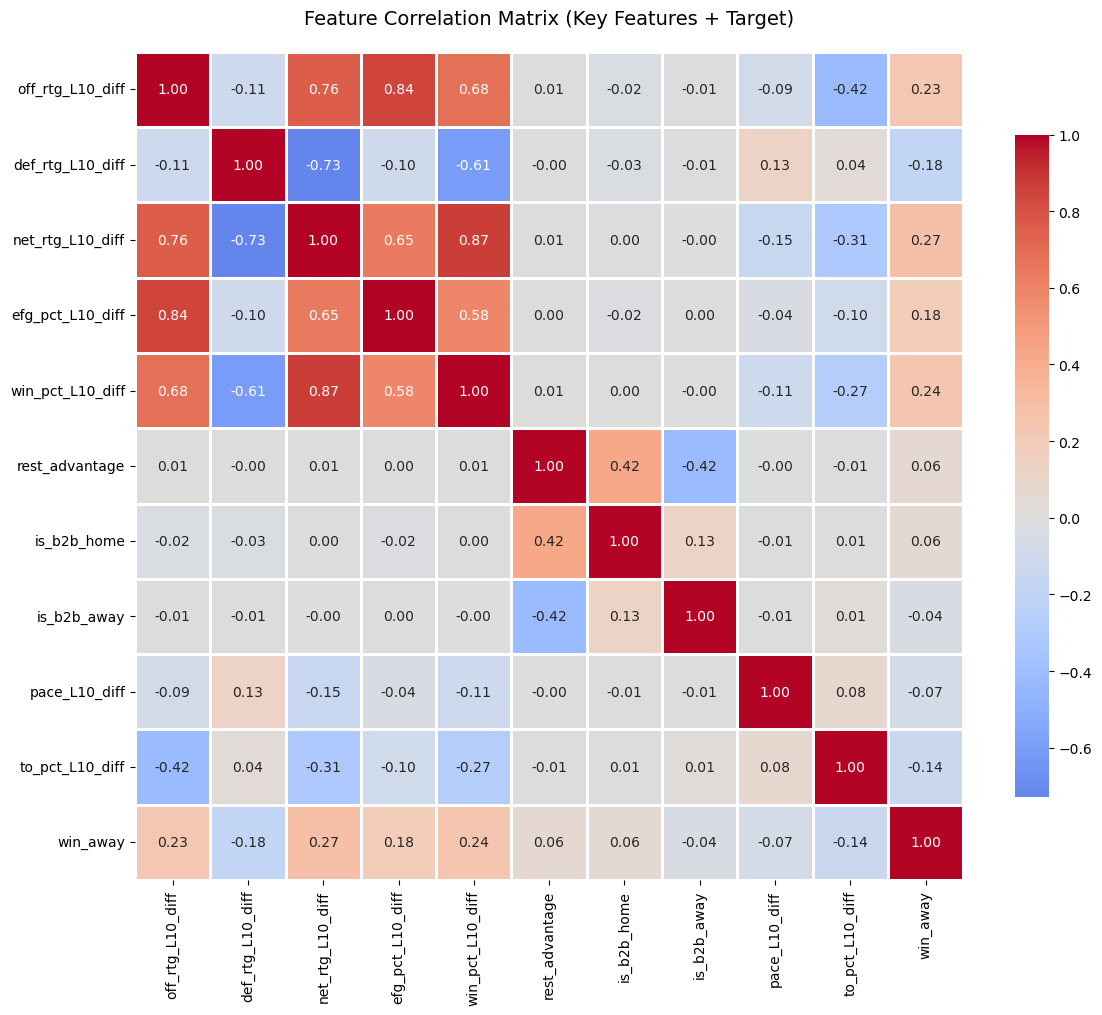


Note: Showing key features only for readability. Full feature list has 19 features.


In [22]:
# Correlation heatmap for key features (keep it focused for readability)
key_viz_features = ['off_rtg_L10_diff', 'def_rtg_L10_diff', 'net_rtg_L10_diff', 
                    'efg_pct_L10_diff', 'win_pct_L10_diff', 'rest_advantage',
                    'is_b2b_home', 'is_b2b_away', 'pace_L10_diff', 'to_pct_L10_diff']

plt.figure(figsize=(12, 10))
corr_matrix = matchups_clean[key_viz_features + ['win_away']].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix (Key Features + Target)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

print("\nNote: Showing key features only for readability. Full feature list has 19 features.")


## 8. Save Processed Data

Save both the individual game data and the matchup dataset.


In [23]:
# Save the processed game data (with rolling features)
games_clean = games.dropna(subset=['off_rtg_L10'])
games_clean.to_csv('nba_games_with_features.csv', index=False)
print(f"✓ Saved: nba_games_with_features.csv ({len(games_clean):,} rows)")

# Save the matchup dataset (ready for modeling)
matchups_clean.to_csv('nba_matchups_with_features.csv', index=False)
print(f"✓ Saved: nba_matchups_with_features.csv ({len(matchups_clean):,} rows)")

print("\n" + "="*70)
print("DATA WRANGLING COMPLETE! (Season 2022+)")
print("="*70)



✓ Saved: nba_games_with_features.csv (10,442 rows)
✓ Saved: nba_matchups_with_features.csv (5,145 rows)

DATA WRANGLING COMPLETE! (Season 2022+)


---

## Summary

**What we did:**
1. ✓ Loaded game data from `team_traditional.csv` (filtered to season 2022+)
2. ✓ Calculated advanced metrics (OFF_RTG, DEF_RTG, NET_RTG, PACE, TO%, etc.)
3. ✓ Calculated rolling features (last 10 games) using point-in-time data (`.shift(1)` to prevent leakage)
4. ✓ Added contextual features (rest days, back-to-backs, win streaks)
5. ✓ Created matchup dataset combining home and away team features
6. ✓ Calculated differentials (away - home) for each feature
7. ✓ Cleaned data 
8. ✓ Saved processed datasets

**Output files:**
- `nba_games_with_features.csv` - Individual game data with rolling features (2022+)
- `nba_matchups_with_features.csv` - Matchup data ready for modeling (2022+)

**All Features (19 total):**

**Advanced Efficiency:**
1. `off_rtg_L10_diff` - Offensive Efficiency Gap (pts per 100 possessions)
2. `def_rtg_L10_diff` - Defensive Efficiency Gap (pts allowed per 100 possessions)
3. `net_rtg_L10_diff` - Overall Quality Gap (Net Rating)

**Shooting Efficiency:**
4. `efg_pct_L10_diff` - Shooting Efficiency Gap (eFG%)
5. `3p_pct_L10_diff` - Sniper Gap (3P%)
6. `3pa_rate_L10_diff` - 3-Point Volume Gap

**Form:**
7. `win_pct_L10_diff` - Recent Form Gap (win rate)

**Tempo & Ball Control:**
8. `pace_L10_diff` - Tempo Gap (possessions per game)
9. `to_pct_L10_diff` - Ball Security Gap (TO%)
10. `ft_rate_L10_diff` - Free Throw Gap (FTA/FGA)

**Rebounding & Playmaking:**
11. `oreb_pct_L10_diff` - Rebounding Gap (OREB%)
12. `ast_ratio_L10_diff` - Ball Movement Gap (AST ratio)

**Defense:**
13. `stl_pct_L10_diff` - Disruption Gap (STL%)
14. `blk_pct_L10_diff` - Rim Protection Gap (BLK%)

**Consistency & Momentum:**
15. `pts_std_L10_diff` - Consistency Gap (scoring volatility)
16. `win_streak_diff` - Momentum Gap (win streak)

**Rest/Fatigue:**
17. `rest_advantage` - Rest Days Gap
18. `is_b2b_home` - Home Team Fatigue (back-to-back)
19. `is_b2b_away` - Away Team Fatigue (back-to-back)

**Target variable:** `win_away` (1 = away team wins, 0 = home team wins)


In [24]:
# Quick peek at final dataset structure
print("Final matchup dataset structure:")
print(f"Shape: {matchups_clean.shape}")
print(f"\nSample with key features:")
display_cols = ['date', 'team_home', 'team_away', 'win_away', 'off_rtg_L10_diff', 
                'def_rtg_L10_diff', 'net_rtg_L10_diff', 'win_pct_L10_diff', 'rest_advantage']
matchups_clean[display_cols].head(10)


Final matchup dataset structure:
Shape: (5145, 148)

Sample with key features:


,date,team_home,team_away,win_away,off_rtg_L10_diff,def_rtg_L10_diff,net_rtg_L10_diff,win_pct_L10_diff,rest_advantage
1,2021-10-25,ATL,DET,0.0,-20.780528,1.089627,-21.870155,-0.500000,0.0
2,2021-11-01,ATL,WAS,0.0,0.024719,-3.371238,3.395957,0.333333,0.0
3,2021-11-04,ATL,UTA,1.0,0.812489,-9.372172,10.184661,0.357143,1.0
4,2021-11-14,ATL,MIL,0.0,-0.307671,-9.994683,9.687012,0.200000,0.0
5,2021-11-15,ATL,ORL,0.0,-9.549487,-8.045196,-1.504291,0.000000,1.0
6,2021-11-17,ATL,BOS,0.0,-5.104694,-12.697832,7.593138,0.200000,0.0
7,2021-11-20,ATL,CHA,0.0,-7.527280,-5.414234,-2.113046,0.100000,-2.0
8,2021-11-22,ATL,OKC,0.0,-12.301975,-9.639307,-2.662668,0.100000,0.0
9,2021-11-27,ATL,NYK,1.0,-14.056026,-1.336690,-12.719336,-0.300000,0.0
10,2021-12-03,ATL,PHI,1.0,-13.680900,2.012886,-15.693786,-0.500000,0.0


**Data is now ready for modeling!**

The dataset has been filtered to seasons 2022+ and includes 19 advanced features based on efficiency metrics, shooting, tempo, defense, and momentum indicators. 

In [25]:
#these should return nothing, bc each game should have one winner and one loser
print(matchups_clean[(matchups_clean['win_home'] == 0.0) & (matchups_clean['win_away'] == 0.0)])
print(matchups_clean[(matchups_clean['win_home'] == 1.0) & (matchups_clean['win_away'] == 1.0)])

Empty DataFrame
Columns: [gameid, date, type_home, teamid_home, team_home, home_home, away_home, MIN_home, PTS_home, FGM_home, FGA_home, FG%_home, 3PM_home, 3PA_home, 3P%_home, FTM_home, FTA_home, FT%_home, OREB_home, DREB_home, REB_home, AST_home, TOV_home, STL_home, BLK_home, PF_home, +/-_home, win_home, season, opp_pts_home, possessions_home, opp_possessions_home, opp_fga_home, opp_3pa_home, opp_2pa_home, opp_dreb_home, off_rtg_home, def_rtg_home, net_rtg_home, pace_home, to_pct_home, ft_rate_home, oreb_pct_home, ast_ratio_home, stl_pct_home, blk_pct_home, off_rtg_L10_home, def_rtg_L10_home, net_rtg_L10_home, eFG%_home, efg_pct_L10_home, 3p_pct_L10_home, 3pa_rate_home, 3pa_rate_L10_home, win_pct_L10_home, pace_L10_home, to_pct_L10_home, ft_rate_L10_home, oreb_pct_L10_home, ast_ratio_L10_home, stl_pct_L10_home, blk_pct_L10_home, pts_std_L10_home, rest_days_home, is_b2b_home, game_num_home, win_streak_home, type_away, teamid_away, team_away, home_away, away_away, MIN_away, PTS_away, F